## Load data

In [1]:
import numpy as np
import _pickle as pkl
import torch
import torch.nn as nn
from torchvision import transforms
%matplotlib inline 
import matplotlib.pyplot as plt
import os, sys, time
sys.path.append('../..')
from utils import set_seed_torch, rgb2gray
set_seed_torch(3)
from argparse import Namespace
import json
from utils import load_models, load_vh_models, frame_stack

In [2]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
args = ObjectView({
 'res': 64,
 'dataset_path': '/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/{}'
                   .format("visual_haptic_2D_len16_osc_withGT_8C12919B740845539C0E75B5CBAF7965.pkl"),
 'models_dir': '/home/olimoyo/visual-haptic-dynamics/saved_models/{}'
                   .format("vaughan/osc/"),
 'device': 'cuda:1',
 'n_examples': 3,
 'n_pred': 8,
 'n_initial': 4
})

def load_models_dir(models_dir):
    """Load hyperparameters from trained model."""
    dict_of_models = {}
    for filedir in os.listdir(models_dir):
        fullpath = os.path.join(models_dir, filedir)
        if os.path.isdir(fullpath):
            with open(os.path.join(fullpath, 'hyperparameters.txt'), 'r') as fp:
                dict_of_models[fullpath] = Namespace(**json.load(fp))
    return dict_of_models

In [3]:
with open(args.dataset_path, 'rb') as f:
    raw_data = pkl.load(f)

data = {}
data['img_rgb'] = torch.from_numpy(raw_data["img"].transpose(0, 1, 4, 2, 3)).int().to(device=args.device)
data['img_gray'] = torch.from_numpy(rgb2gray(raw_data["img"]).transpose(0, 1, 4, 2, 3)).float().to(device=args.device)
data['haptic'] = torch.from_numpy(raw_data['ft']).float().to(device=args.device) / 100.0
data['arm'] = torch.from_numpy(raw_data['arm']).float().to(device=args.device)

data['actions'] = torch.from_numpy(raw_data["action"]).to(device=args.device).float()

## Visualize

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vaughan/osc/nstep2_z16_net512_l0_lm_osc_v_r0.95_kl0.80_lr3e4
MSE of predictions:  [1.1907532 2.916885  3.425177  3.0748584 2.0024385 1.6805155 2.6497958
 2.1684794]


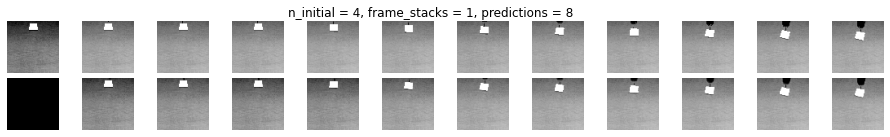

MSE of predictions:  [0.6221265 2.697662  1.2501309 1.6994814 1.2576904 1.1475767 1.960973
 1.799217 ]


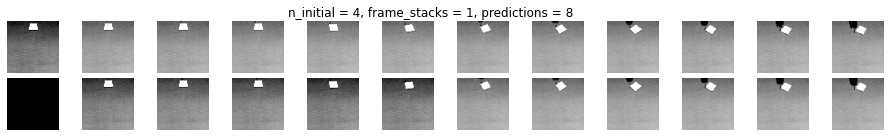

MSE of predictions:  [2.301543  2.673797  2.9354236 2.1323555 1.2253337 1.2347348 1.4891232
 2.048813 ]


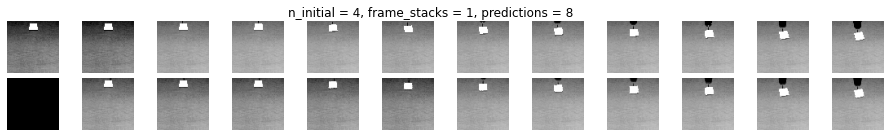

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vaughan/osc/none_z16_net512_l0_lm_osc_v_r0.95_kl0.80_lr3e4
MSE of predictions:  [0.9259023 1.428001  1.505692  1.6083268 2.3310742 4.9441895 4.0826416
 4.681255 ]


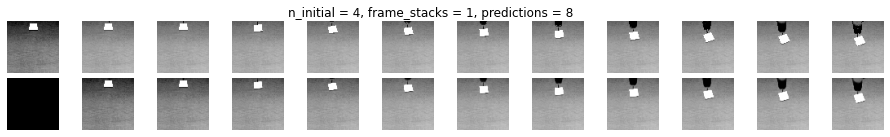

MSE of predictions:  [2.4333827 1.8479993 3.5498521 4.225959  5.057575  6.4705377 6.1805186
 8.867539 ]


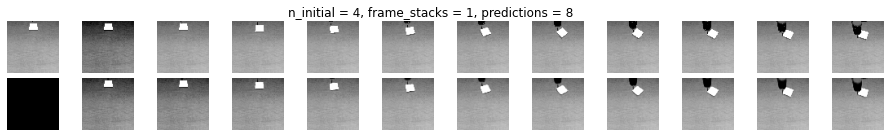

MSE of predictions:  [0.62888813 0.45039788 1.2983258  2.5274718  2.6000023  3.7162535
 3.7939842  5.2624207 ]


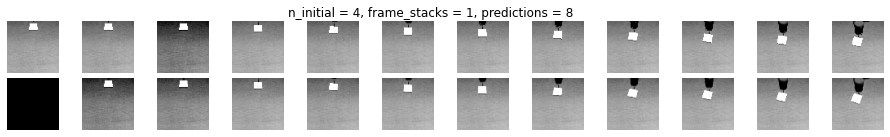

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vaughan/osc/goallatent_z16_net512_l0_lm_osc_vha_r0.95_kl0.80_lr3e4
MSE of predictions:  [0.9225435 2.1226335 3.978525  2.0245254 3.6557786 2.9839485 4.584959
 4.380008 ]


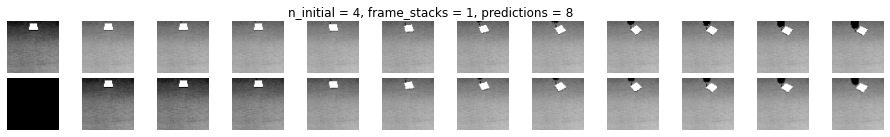

MSE of predictions:  [ 1.5305438  2.1377082  3.800484   5.871883   8.576869  12.864573
 15.017161  18.07425  ]


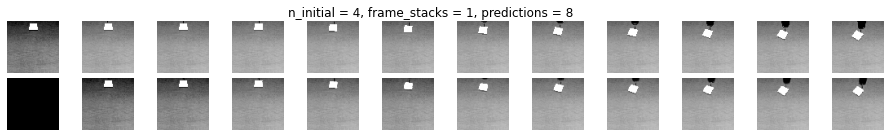

MSE of predictions:  [ 0.6922701  1.7931653  2.624823   4.1453247  4.562691   6.035206
  8.02873   10.342862 ]


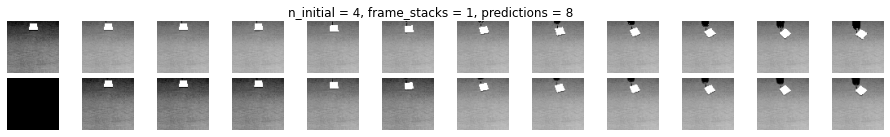

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vaughan/osc/allpaststates_z16_net512_l0_lm_osc_v_r0.95_kl0.80_lr3e4
MSE of predictions:  [ 0.42970735  0.5755096   2.3605547   6.831621   11.875332   13.945683
 15.659341   15.647307  ]


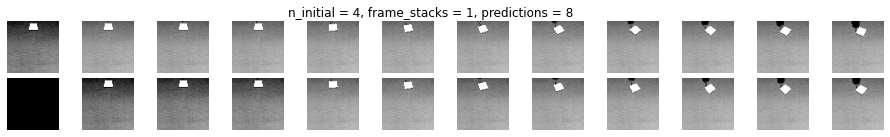

MSE of predictions:  [0.04980904 0.37644172 1.186608   1.7565662  2.1182117  2.3355198
 2.349815   1.811054  ]


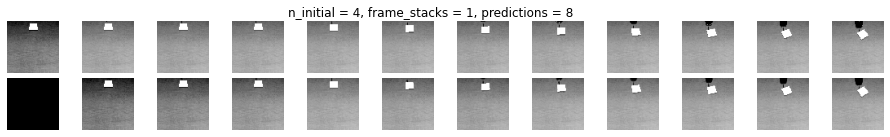

MSE of predictions:  [0.12984785 2.2869859  1.2541316  3.147993   3.075259   4.78007
 5.297828   8.0399885 ]


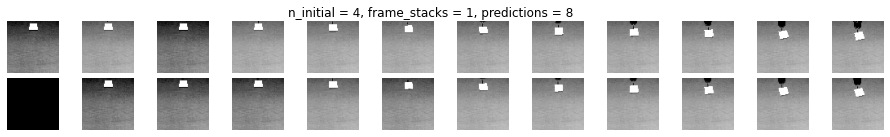

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vaughan/osc/goallatent_z16_net512_l0_lm_osc_v_r0.95_kl0.80_lr3e4
MSE of predictions:  [ 2.0078156  2.6404479  6.1439734  9.635609  13.277573  15.149939
 17.06519   17.916855 ]


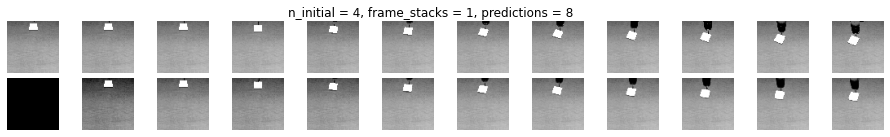

MSE of predictions:  [ 6.023694  5.526396  7.37044   7.704507  9.539011 12.697173 11.562268
 18.99997 ]


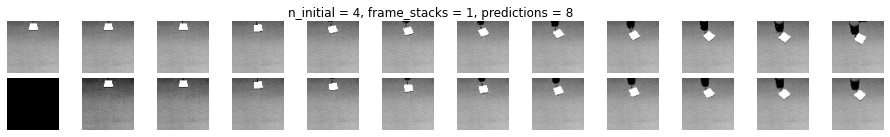

MSE of predictions:  [ 2.0296133  3.5831141  6.469354   9.903254  10.072366  11.369589
  9.454492  14.970938 ]


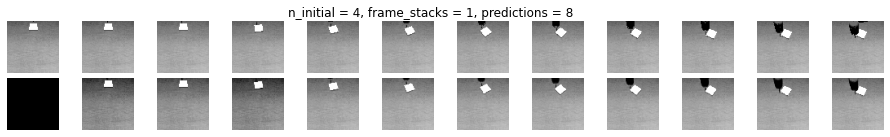

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vaughan/osc/nstep2_z16_net512_l0_lm_osc_vha_r0.95_kl0.80_lr3e4
MSE of predictions:  [0.97665507 2.309191   3.4788404  1.9084489  4.834819   8.645266
 4.953118   7.4461207 ]


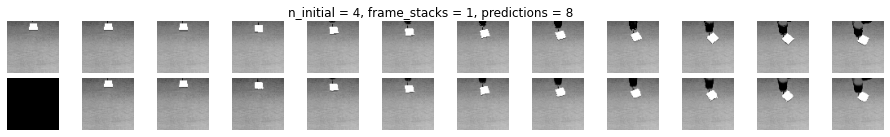

MSE of predictions:  [2.8861043 1.9009914 2.1785555 1.8424642 2.5662327 3.4769752 4.9528737
 4.017966 ]


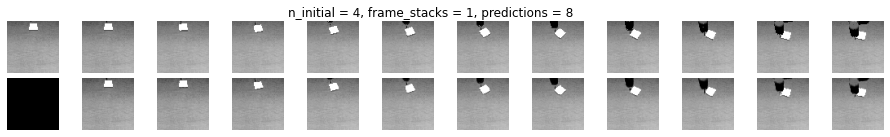

MSE of predictions:  [1.197324  1.2754107 2.8363008 3.8988574 2.2492993 3.0740259 6.715499
 4.3025637]


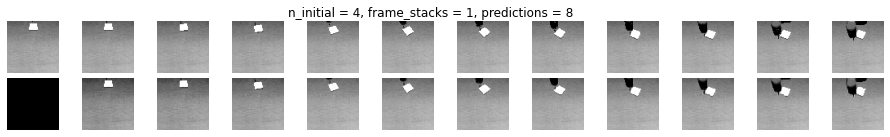

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vaughan/osc/z16_net512_l0_lm_ul_osc_v_r0.95_kl0.80_lr3e4
MSE of predictions:  [0.65915847 1.1815333  0.5993171  0.9665087  2.14911    4.630111
 5.339266   6.436358  ]


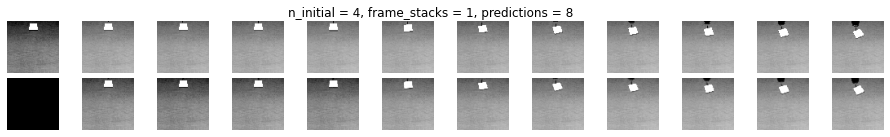

MSE of predictions:  [ 2.2441063  3.5807164  2.5544546  5.981316   7.767263   8.06281
 14.584087  14.95121  ]


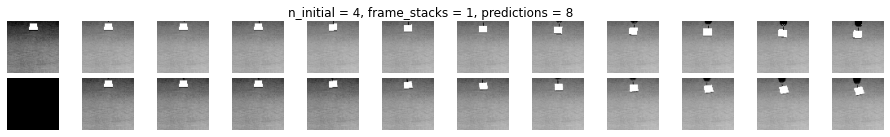

MSE of predictions:  [0.8622632  0.26649216 0.5201558  1.4192133  0.7016265  3.0005398
 2.51902    5.083876  ]


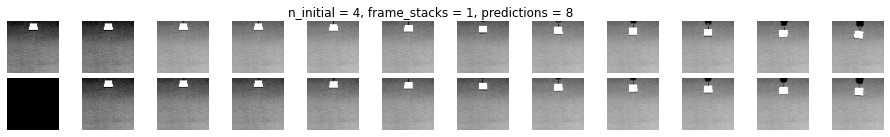

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vaughan/osc/allpaststates_z16_net512_l0_lm_osc_vha_r0.95_kl0.80_lr3e4
MSE of predictions:  [ 0.3730557  1.7335349  4.0247827  3.3353803  6.249192   9.918893
 13.55387   15.354282 ]


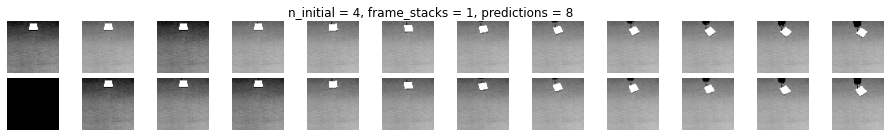

MSE of predictions:  [ 0.3325785   0.30605456  3.5262759   5.559383    6.82216     6.053757
 11.467782    7.38244   ]


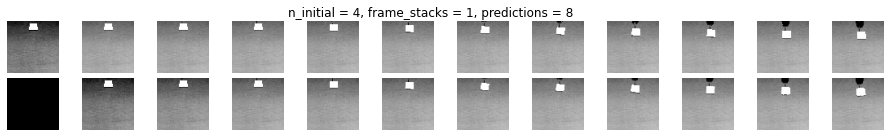

MSE of predictions:  [0.10394153 0.4349626  0.8120617  1.3936286  1.3268696  3.1946058
 0.9058092  2.1822803 ]


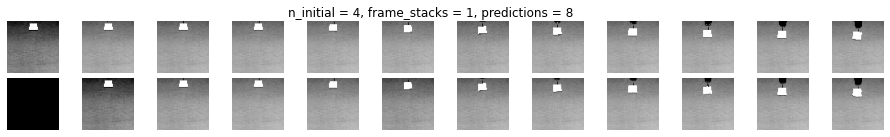

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vaughan/osc/z16_net512_l0_lm_osc_vha_r0.95_kl0.80_lr3e4
MSE of predictions:  [1.4825522 2.0809023 1.8493125 2.4848819 3.9124815 4.1931634 2.1795049
 2.3924174]


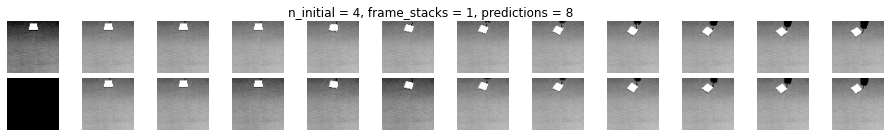

MSE of predictions:  [2.9835305 1.3532773 1.640464  2.8081207 1.92271   3.7172227 2.6122026
 2.9458575]


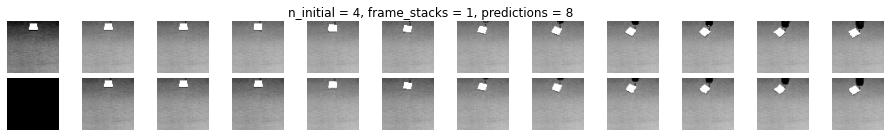

MSE of predictions:  [2.1888542 1.7148688 1.4242533 3.2453454 1.4631103 2.8142645 2.7341063
 3.1003065]


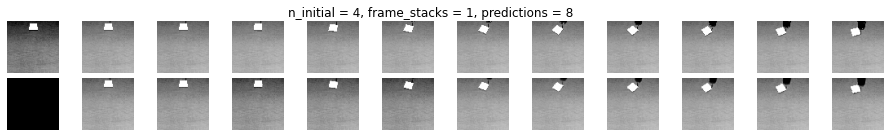

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vaughan/osc/none_z16_net512_l0_lm_osc_vha_r0.95_kl0.80_lr3e4
MSE of predictions:  [1.0623429 1.4313263 1.9060004 3.3835049 3.6399689 4.3748217 4.267397
 6.803544 ]


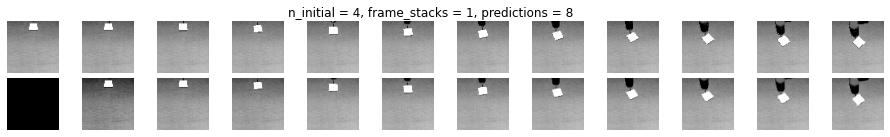

MSE of predictions:  [0.8735878 1.4789879 2.3793166 1.3744614 1.9795817 1.5942439 3.3333316
 3.8001475]


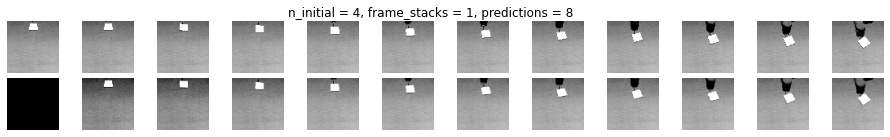

MSE of predictions:  [1.0037982 1.6646018 1.5744509 1.2486112 1.8916945 2.1033037 3.269348
 4.1548605]


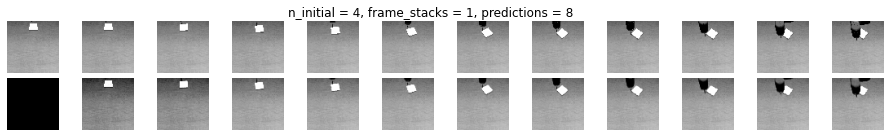

In [15]:
dict_of_models = load_models_dir(args.models_dir)

with torch.no_grad():
    for path, model_args in dict_of_models.items():
            
        nets = load_vh_models(path=path, args=model_args, mode='eval', device=args.device)
        
        def encode(nets, x_img, x_ft, x_arm, ctx_img):
            if model_args.context_modality != "none":
                if model_args.context_modality == "joint": 
                    ctx = torch.cat((x_ft, x_arm), dim=-1) # (n, l, f, 12)
                elif model_args.context_modality == "ft": 
                    ctx = x_ft
                elif model_args.context_modality == "arm":
                    ctx = x_arm
                ctx = ctx.float().to(device=args.device) # (n, l, f, 6)
                ctx = ctx.transpose(-1, -2)
                ctx = ctx.reshape(-1, *ctx.shape[2:])
                
            n, l = x_img.shape[0], x_img.shape[1]

            if model_args.context in ["initial_image", "goal_image"]:
                x_img = torch.cat((x_img, ctx_img.repeat(1, l, 1, 1, 1)), dim=2)
            
            z_all_enc = []
            z_img = nets["img_enc"](x_img.reshape(-1, *x_img.shape[2:]))
            z_all_enc.append(z_img)  

            if model_args.context_modality != "none":
                z_context = nets["context_enc"](ctx)
                z_all_enc.append(z_context)   
            
            if model_args.context in ["initial_latent_state", "goal_latent_state"]:
                z_img_context = nets["context_img_enc"](ctx_img)
                z_img_context_rep = z_img_context.unsqueeze(1).repeat(1, l, 1)
                z_all_enc.append(z_img_context_rep.reshape(-1, *z_img_context_rep.shape[2:]))        
                ret_context = z_img_context
            elif model_args.context in ["all_past_states"]:
                if l > 1:
                    z_img_context, h_img_context = nets["context_img_rnn_enc"](
                        z_img.reshape(n, l, *z_img.shape[1:])[:, :-1].transpose(1,0)
                    )
                    pad = torch.zeros((1, *z_img_context.shape[1:])).float().to(device=args.device)
                    z_img_context_latest, h_img_context_latest = nets["context_img_rnn_enc"](
                        z_img.reshape(n, l, *z_img.shape[1:]).transpose(1,0)
                    )
                    z_img_context = torch.cat((pad, z_img_context), dim=0)
                    z_img_context = z_img_context.transpose(1, 0)
                    ret_context = (z_img_context_latest.transpose(1, 0), h_img_context_latest)
                else:
                    z_img_context = torch.zeros((n, l, 16)).float().to(device=args.device)
                    ret_context = (z_img_context, None)
                z_all_enc.append(z_img_context.reshape(-1, *z_img_context.shape[2:]))
            else:
                ret_context = None
                        
            z_cat_enc = torch.cat(z_all_enc, dim=-1)
            z, mu_z, logvar_z = nets["mix"](z_cat_enc)
            var_z = torch.diag_embed(torch.exp(logvar_z))
            
            return z, mu_z, var_z, ret_context
        
        if model_args.dim_x[0] == 1:
            img_key = 'img_gray'
        elif model_args.dim_x[0] == 3:
            img_key = 'img_rgb'
                    
        T = model_args.frame_stacks
        
        assert args.n_initial + args.n_pred <= data[img_key].shape[1]
        assert args.n_initial > T
        
        # Use a random batch to test
        ii = np.random.randint(data[img_key].shape[0] // args.n_examples)
        batch_range = range(args.n_examples*ii, args.n_examples*(ii+1))
        test_batch = {k:v[batch_range] for k,v in data.items()}
        
        # Ground truth images and controls
        x_img = test_batch[img_key][:, :(args.n_initial + args.n_pred)]
        u = test_batch['actions']
        
        # Sequence of initial images
        x_img_i = x_img[:, :args.n_initial]
        x_img_i = frame_stack(x_img_i, frames=T)
        
        # Sequence of ground truth images
        x_img_gt = x_img[:, -(T + 1):]
        x_img_gt = frame_stack(x_img_gt, frames=T)
        
        # Sequence of extra modalities
        x_ft_i = test_batch['haptic'][:, T:args.n_initial]
        x_arm_i = test_batch['arm'][:, T:args.n_initial]

        n, l = x_img_i.shape[0], x_img_i.shape[1] 

        if model_args.context in ["initial_latent_state", "initial_image"]:
            ctx_img = x_img_i[:, 0]
        elif model_args.context in ["goal_latent_state", "goal_image"]:
            ctx_img = x_img_gt[:, -1]
        else:
            ctx_img = None

        # Encode
        z_ini, mu_z_ini, var_z_ini, ret_context = encode(nets, x_img_i, x_ft_i, x_arm_i, ctx_img)
        
        if model_args.context in ["all_past_states"]:
            z_img_context, h_img_context = ret_context
        else:
            z_img_context = ret_context
        h_i = None
                
        # Group and prepare for prediction
        q_z_i = {"z": z_ini, "mu": mu_z_ini, "cov": var_z_ini}
        q_z_i = {k:v.reshape(n, l, *v.shape[1:]).transpose(1,0) for k, v in q_z_i.items()}
        u = u.transpose(1,0)

        z_hat = torch.zeros(((l + args.n_pred), n, model_args.dim_z)).to(device=args.device)
        z_hat[0:l] = q_z_i["mu"]
        
        # First run
        z_i, mu_z_i, var_z_i = q_z_i["z"], q_z_i["mu"], q_z_i["cov"]
        u_i = u[(T + 1):(1 + args.n_initial)]
        
        # Predict
        for jj in range(0, args.n_pred):
            z_ip1, mu_z_ip1, var_z_ip1, h_ip1 = nets["dyn"](
                z_t=z_i, 
                mu_t=mu_z_i, 
                var_t=var_z_i, 
                u=u_i, 
                h_0=h_i, 
                single=False
            )
            z_hat[jj + l] = mu_z_ip1[-1]
            z_i, mu_z_i, var_z_i, h_i = z_ip1[-1:], mu_z_ip1[-1:], var_z_ip1[-1:], h_ip1
            u_i = u[1 + args.n_initial + jj][None]
            if model_args.context in ["all_past_states"]:
                z_img_context_dec = z_img_context[:, -1]
                z_cat_single_dec = torch.cat((mu_z_ip1[-1], z_img_context_dec), dim=-1)
                x_hat_ip1 = nets["img_dec"](z_cat_single_dec)
                z_img_ip1 = nets["img_enc"](x_hat_ip1)
                z_img_context_ip1, h_img_context = nets["context_img_rnn_enc"](z_img_ip1.unsqueeze(0), h=h_img_context)
                z_img_context = torch.cat((z_img_context, z_img_context_ip1.transpose(1,0)), dim=1)
                
        z_hat = z_hat.transpose(1, 0)
        
        # Decode
        z_all_dec = []
        z_all_dec.append(z_hat)

        if model_args.context in ["initial_latent_state", "goal_latent_state"]:
            z_img_context_rep = z_img_context.unsqueeze(1).repeat(1, (l + args.n_pred), 1)
            z_all_dec.append(z_img_context_rep)
        elif model_args.context in ["all_past_states"]:
            z_img_context = z_img_context.transpose(1, 0)
            pad = torch.zeros((1, *z_img_context.shape[1:])).float().to(device=args.device)
            z_img_context = torch.cat((pad, z_img_context[:-1]), dim=0)
            z_img_context = z_img_context.transpose(1, 0)
            z_all_dec.append(z_img_context)

        z_cat_dec = torch.cat(z_all_dec, dim=-1)
        x_hat = nets["img_dec"](z_cat_dec.reshape(-1, *z_cat_dec.shape[2:]))
        x_hat = x_hat.reshape(n, (l + args.n_pred), *x_hat.shape[1:])
                
        # Move to cpu, np
        x_hat = x_hat.cpu().numpy()
        x_img = x_img.cpu().numpy()

        mse = np.sum((x_hat[:, l:, 0].reshape(n, args.n_pred, -1) - 
                      x_img[:, args.n_initial:, 0].reshape(n, args.n_pred, -1))**2, axis=2)

        # Plotting
        for bb in range(n):
            columns = args.n_initial + args.n_pred
            rows = 2
            fig=plt.figure(figsize=(16, 2))
            fig.suptitle('n_initial = {}, frame_stacks = {}, predictions = {}'.format(args.n_initial, T, args.n_pred))
            for ii in range(columns*rows):
                if ii<((columns*rows)/2):
                    img = x_img[bb,ii,0,:,:]
                else:
                    idx = int(ii-((columns*rows)/2))
                    if idx < T:
                        img = np.zeros((model_args.dim_x[1], model_args.dim_x[2]))
                    else:
                        img = x_hat[bb,idx-1,0,:,:]
                fig.add_subplot(rows, columns, ii+1)
                plt.imshow(img, cmap="gray")
                
                plt.axis('off')
            print("MSE of predictions: ", mse[bb])
            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            plt.show()